In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

0
10.1%. Run time:   2.02s. Est. time left: 00:00:00:17
20.2%. Run time:   3.91s. Est. time left: 00:00:00:15
30.3%. Run time:   5.54s. Est. time left: 00:00:00:12
40.4%. Run time:   7.19s. Est. time left: 00:00:00:10
50.5%. Run time:   8.88s. Est. time left: 00:00:00:08
60.6%. Run time:  10.88s. Est. time left: 00:00:00:07
70.7%. Run time:  12.98s. Est. time left: 00:00:00:05
80.8%. Run time:  14.88s. Est. time left: 00:00:00:03
90.9%. Run time:  16.89s. Est. time left: 00:00:00:01
100.0%. Run time:  19.47s. Est. time left: 00:00:00:00
Total run time:  19.47s
|alpha|^2 = 0j
<n> = 0j
1
10.1%. Run time:   5.17s. Est. time left: 00:00:00:46
20.2%. Run time:   8.71s. Est. time left: 00:00:00:34
30.3%. Run time:  12.89s. Est. time left: 00:00:00:29
40.4%. Run time:  17.46s. Est. time left: 00:00:00:25
50.5%. Run time:  22.44s. Est. time left: 00:00:00:21
60.6%. Run time:  27.01s. Est. time left: 00:00:00:17
70.7%. Run time:  33.18s. Est. time left: 00:00:00:13
80.8%. Run time:  37.16s. Est

In [ ]:
# System Parameters

# Physical parameters
omega_c = 2 * np.pi * 6.826  # Cavity frequency (nu_c = 6.826 GHz)
omega_q = 2 * np.pi * 5.0258  # Qubit frequency (nu_q = 5.0258 GHz)
omega_r = 0.9 * omega_q  # Qubit drive frequency (near qubit frequency)
omega_d = 0.9 * omega_c  # Drive frequency (near cavity frequency)
chi = 2 * np.pi * -0.66 * 1e-3  # Dispersive coupling strength (chi / 2 pi = -0.66 MHz)
kappa = 2 * np.pi * 4.3 * 1e-3  # Linewidth (kappa / 2 pi = 4.3 MHz)
Omega_R = 2 * np.pi * 9 * 1e-3  # Rabi frequency (Nu_R = 9 MHz) (same as -Delta_c)

T_phi = 1  # Qubit pure dephasing time
Gamma_phi = 1 / T_phi  # Qubit pure dephasing rate
T_2 = 10.6 * 1e-6  # Qubit lab frame dephasing rate (T_2 = 10.6 μs)

# System dimensions
N_cavity = 10  # Number of Fock states for cavity
N_qubit = 2  # Number of states for qubit

# Time range
time_range = np.linspace(0, 10, 100)

# Calculate detuning
# Delta_c = omega_d - omega_c  # Cavity detuning (same as -Omega_R)
Delta_c = -Omega_R  # Cavity detuning (same as -Omega_R)

In [ ]:
# Define Operators

# Identity operators
I_c = qt.qeye(N_cavity)  # Cavity identity operator
I_q = qt.qeye(N_qubit)  # Qubit identity operator

# Cavity operators
a = qt.tensor(qt.destroy(N_cavity), I_q)  # Cavity annihilation operator
n = a.dag() * a  # Cavity number operator

# Qubit operators
sigma_x = qt.tensor(I_c, qt.sigmax())  # Qubit X operator
sigma_z = qt.tensor(I_c, qt.sigmaz())  # Qubit Z operator
sigma_plus = qt.tensor(I_c, qt.create(N_qubit))  # Qubit raising operator
sigma_minus = qt.tensor(I_c, qt.destroy(N_qubit))  # Qubit lowering operator

In [ ]:
# Define Displacement-dependent Functions

def hamiltonian(displacement):

    # Define displacement operator
    d = qt.tensor(qt.destroy(N_cavity) - displacement, I_q)

    # omega_q_ac = omega_q + chi * (2 * np.abs(displacement)**2)
    # omega_r = omega_q_ac
    # Delta_q = omega_q - omega_r  # Qubit detuning
    Delta_q = 0  # Qubit detuning

    # Define the Hamiltonian components
    H_cavity = -Delta_c * d.dag() * d
    H_qubit = -0.5 * (Delta_q + chi * (2 * np.abs(displacement)**2)) * sigma_z
    H_rabi = -0.5 * Omega_R * sigma_x
    H_int = -chi * (np.conj(displacement) * d + displacement * d.dag() + d.dag() * d) * sigma_z
    
    return H_cavity + H_qubit + H_rabi + H_int

def Gamma_plus(displacement):
    return 4 * chi**2 * np.abs(displacement)**2 / kappa + (1 / (2 * T_2))

def Gamma_minus(displacement):
    return kappa * chi**2 * np.abs(displacement)**2 / ((2 * Omega_R)**2 + (kappa / 2)**2) + (1 / (2 * T_2))

In [ ]:
# Simulation

# Range of average photon numbers to simulate
blah = Delta_c + 0.5j * kappa
displacement_range = np.sqrt(np.linspace(0, 10, 10)) * np.abs(blah) / blah

# Define initial state (|0⟩_c ⊗ |+⟩_q)
psi0_cavity = qt.basis(N_cavity, 0)                                # Cavity ground state
psi0_qubit = (qt.basis(N_qubit, 0) + qt.basis(N_qubit, 1)).unit()  # Qubit |+⟩ state
psi0 = qt.tensor(psi0_cavity, psi0_qubit)

# Evaluation operators (observables)
e_ops = {
    'x': sigma_x,
    'z': sigma_z,
    'n': n,
}

options = dict(
    store_states=True,
    progress_bar=True,
    nsteps=50000,      # Increased number of steps
    rtol=1e-6,
    atol=1e-6,
    max_step=0.1,
    method='adams'     # Using Adams method which can be more stable
)

# Arrays to store results
sx_expect = np.zeros_like(displacement_range)
sz_expect = np.zeros_like(displacement_range)
n_expect = np.zeros_like(displacement_range)
a_expect = np.zeros_like(displacement_range)
n_values = np.zeros((len(displacement_range), N_cavity))

for i, displacement in enumerate(displacement_range):
    print(i)

    # Collapse operators (dissipation)
    c_ops = [
        np.sqrt(kappa) * a,
        np.sqrt(Gamma_phi / 2) * sigma_z,
        np.sqrt(Gamma_plus(displacement)) * sigma_plus,
        np.sqrt(Gamma_minus(displacement)) * sigma_minus
    ]

    H = hamiltonian(displacement)
    
    result = qt.mesolve(H, psi0, time_range, c_ops, options=options)
    rho_final = result.states[-1]

    # Store final expectation values from time evolution
    sx_expect[i] = qt.expect(sigma_x, rho_final)
    sz_expect[i] = qt.expect(sigma_z, rho_final)
    n_expect[i] = qt.expect(n, rho_final)
    a_expect[i] = np.abs(qt.expect(a, rho_final))**2
    print('|alpha|^2 =', a_expect[i])
    print('<n> =', n_expect[i])

    # Calculate expectation value of |j⟩ over time
    for j in range(N_cavity):

        # Create projection operator for |j⟩ state
        P = qt.tensor(qt.basis(N_cavity, j) * qt.basis(N_cavity, j).dag(), I_q)

        # Calculate expectation value
        n_values[i, j] = qt.expect(P, rho_final)

n_bar_values = abs(displacement_range)**2

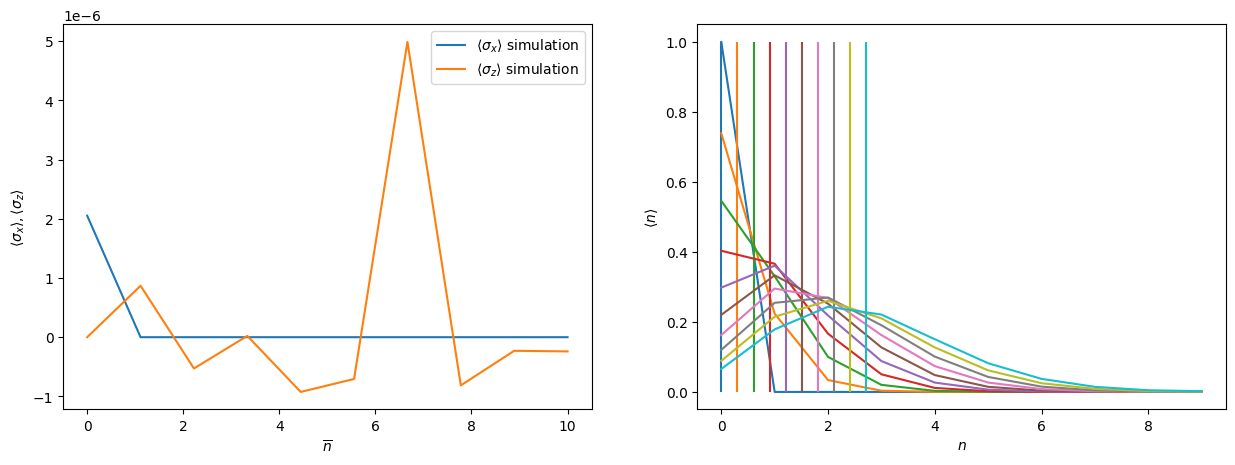

In [4]:
# Visualization

fig = plt.figure(figsize=(15, 5))

# Plot qubit observables
ax1 = fig.add_subplot(121)
ax1.plot(n_bar_values, sx_expect, label='$\\langle\\sigma_x\\rangle$ simulation')
ax1.plot(n_bar_values, sz_expect, label='$\\langle\\sigma_z\\rangle$ simulation')
ax1.set_xlabel('$\\overline{n}$')
ax1.set_ylabel('$\\langle\\sigma_x\\rangle, \\langle\\sigma_z\\rangle$')
ax1.legend()

ax2 = fig.add_subplot(122)
for i in range(len(displacement_range)):
    plot = ax2.plot(n_values[i], label=f'$\\langle n \\rangle = {n_expect[i]:.2f}$')
    ax2.vlines(a_expect[i], 0, 1, color=plot[0].get_color(), label=f'$|\\alpha|^2 = {a_expect[i]:.2f}$')
ax2.set_xlabel('$n$')
ax2.set_ylabel('$\\langle n\\rangle$')
# ax2.legend()

plt.show()